This notebook applies to real data over a small region (perhaps just one pixel).

In [1]:
import datacube
datacube.config.LocalConfig.db_database = 'wofstest'
datacube.config.LocalConfig.db_hostname = 'agdcstaging-db'
dc = datacube.Datacube()

In [2]:
lon = 143.83756, 143.88605
lat = -30.55194, -30.59073
stack = dc.load(product='wofs_albers', lat=lat, lon=lon)

In [3]:
import numpy as np
stack.water.data &= ~np.uint8(4) # remove ocean masking (optional)

In [4]:
wet = stack.water == 128
dry = stack.water == 0
clear = wet | dry
frequency = wet.sum(dim='time') / clear.sum(dim='time')

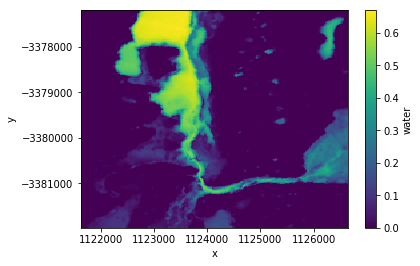

In [5]:
%matplotlib inline
frequency.plot()

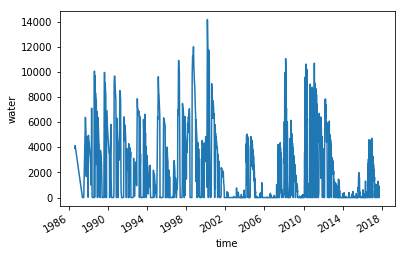

In [6]:
wet.sum(dim=['x','y']).plot()

In [7]:
unobserved = ~clear
unobserved.sum().data / clear.sum().data

0.65850774085053543

In [39]:
unobserved.sum(dim=['x','y']) > 35000

<xarray.DataArray 'water' (time: 1620)>
array([False, False,  True, ..., False, False, False], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 1986-08-17T23:41:32.500000 ...

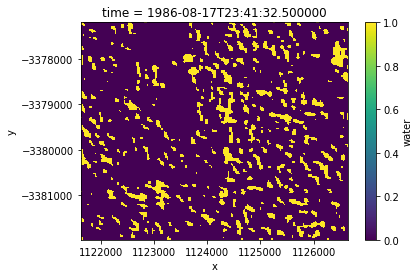

In [9]:
unobserved.isel(time=0).plot()

In [12]:
clear

<xarray.DataArray 'water' (time: 1620, y: 191, x: 201)>
array([[[False, False, ...,  True,  True],
        [False, False, ...,  True,  True],
        ..., 
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ..., 
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ..., 
       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ..., 
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[False, False, ...,  True,  True],
        [False, False, ...,  True,  True],
        ..., 
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 1986-08-17T23:41:32.500000 ...
  * y        (y) float64 -3.377e+06 -3.377e+06 -3.377e+06 -3.377e+06 ...
  * x        (x

In [13]:
clear.diff(dim='time')

<xarray.DataArray 'water' (time: 1619, y: 191, x: 201)>
array([[[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ..., 
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ..., 
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ..., 
       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ..., 
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ..., 
        [False, False, ..., False, False],
        [False, False, ..., False, False]]], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 1986-08-26T23:35:01 ...
  * y        (y) float64 -3.377e+06 -3.377e+06 -3.377e+06 -3.377e+06 ...
  * x        (x) float

In [26]:
clear[:,0,0].astype(np.int8).data[:10]

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int8)

In [27]:
clear.astype(np.int8).diff(dim='time')[:,0,0].data[:10]

array([ 1, -1,  0,  1,  0,  0,  0,  0,  0,  0], dtype=int8)

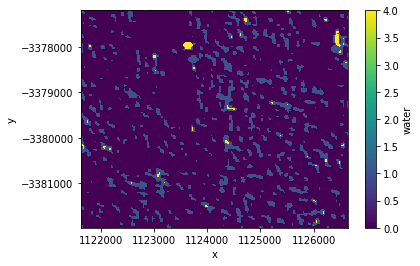

In [37]:
clear.argmax(dim='time').plot() # First clear observation may not be until, say, 4th layer.

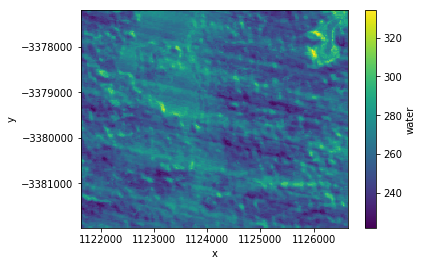

In [50]:
(clear.astype(np.int16).diff(dim='time') == 1).sum(dim='time').plot() # no of no-observation streaks

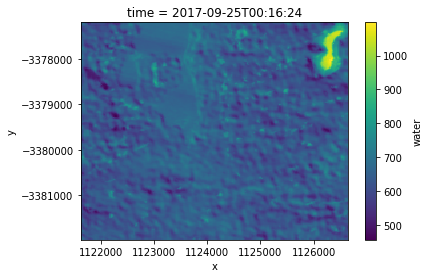

In [55]:
(~clear).astype(np.int16).cumsum(dim='time').isel(time=-1).plot() # now.. just need to do where with diff above..

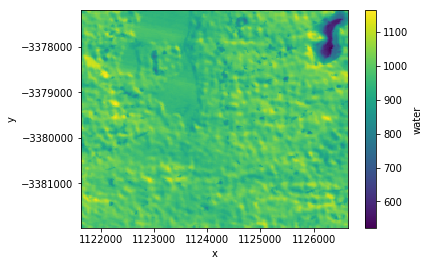

In [56]:
clear.sum(dim='time').plot()

In [59]:
import matplotlib.pyplot as plt

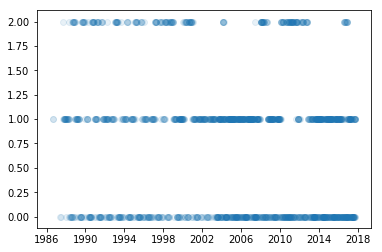

In [84]:
drill = stack.water.isel(x=-1, y=130)
w = drill == 128
d = drill == 0
c = w | d
s = c.astype(np.int8) + w

plt.scatter(s.time.data, s.data, alpha=0.1)

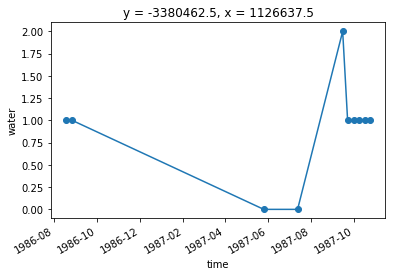

In [87]:
s[:10].plot(marker='o')

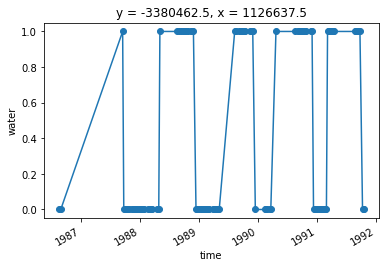

In [94]:
ss = s[s != 0]
ss -= 1
ss[:100].plot(marker='o')

(0, 100)

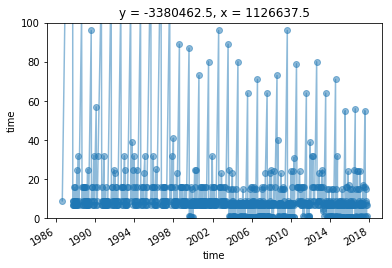

In [111]:
(ss.time.diff(dim='time') / np.timedelta64(1,'D')).plot(marker='o', alpha=0.5)
plt.ylim(0,100)

In [112]:
ss.size

970

In [124]:
dt = ss.time.diff(dim='time')
t0 = ss[0] # value @ time zero
tk = ss[:-1] # value @ time k
tkp = ss[1:] # value @ time k+1

In [131]:
v = np.vstack([tk.data, tkp.data]).T

In [159]:
import itertools
transitions = list(itertools.product(*[[0,1]]*2)) # 4 possible permutations

In [169]:
d = {}
for kind in transitions:
    i = (v == kind).all(axis=1)    
    d[kind] = dt[i].data / np.timedelta64(1,'D')

In [170]:
d

{(0, 0): array([   8.99546875,    8.99584491,    7.00438657,    8.99582176,
           7.00436343,   16.00024306,    8.99583333,    7.004375  ,
           8.99579861,    7.00435185,   16.00018519,    8.99581019,
           7.00438079,    8.99581597,    7.00438657,   24.99599537,
           7.00434028,    8.99576389,    7.00434028,   32.00012731,
           8.99574653,    8.99565394,    7.00429398,   15.99988426,
           8.9955787 ,    7.0043287 ,    8.99570602,    7.00428241,
           8.99561343,    7.0041956 ,   24.9951794 ,    7.00438079,
           8.99573495,    7.00415509,    8.99561343,    7.00425926,
          56.99443287,    7.00414352,    8.99550926,   15.99960648,
           7.00409722,    7.00440972,    8.99583333,    7.00445602,
           8.9958912 ,   16.0002662 ,    7.00425347,    8.99590856,
           7.00438079,    8.99581597,    7.00434028,    8.99569444,
           7.00429398,   24.99586806,    7.00435185,    8.99568287,
          23.00416667,    8.99570602,   

In [171]:
d.keys()

dict_keys([(0, 0), (0, 1), (1, 0), (1, 1)])

In [174]:
d[(1,1)].size, d[(1,1)].mean()

(222, 14.963893294336003)

In [232]:
import itertools, scipy.linalg

def likelihood(filtered_series, ratio, timeconstant):
    #global A, M
    
    wetting = (1/timeconstant) * ratio
    drying = (1/timeconstant) * (1 - ratio)
    
    wet = np.array([1, 0]) # define basis in probability space
    dry = np.array([0, 1])
    
    A = np.array([[-wetting, drying], [wetting, -drying]]) # gradient matrix
    
    transitions = list(itertools.product(*[[0,1]]*2)) # 4 possible permutations
    
    dt = filtered_series.time.diff(dim='time').data / np.timedelta64(1,'D')
    t0 = filtered_series.data[0] # value @ time zero
    tk = filtered_series.data[:-1] # value @ time k
    tkp = filtered_series.data[1:] # value @ time k+1
    change = np.vstack([tk, tkp]).T 
    
    L = np.full(len(filtered_series), np.nan, np.float64)
    
    L[0] = ratio if t0 else (1 - ratio) # == x0 * pi
    
    j = 1    
    for kind in transitions:
        i = (change == kind).all(axis=1) # locate examples of this kind of transition
        
        x0 = wet if kind[0] else dry
        x1 = wet if kind[1] else dry
        
        for t in dt[i]: # get associated time-intervals
        
            M = scipy.linalg.expm(t * A) # evolution matrix
            
            L[j] = M.T[kind] # == x1 * (M * x0)
            j += 1            
    assert j == len(filtered_series)
    
    return np.prod(L)

In [233]:
likelihood(ss, 0.25, 100)

3.4251783063080784e-79

In [261]:
ratio = np.linspace(0.1, 0.9, 40)
tc = np.logspace(-1, 4, 60)

raster = np.full((len(ratio), len(tc)), np.nan, np.float64)
for i,r in enumerate(ratio):
    for j,t in enumerate(tc):
        raster[i,j] = likelihood(ss,r,t)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


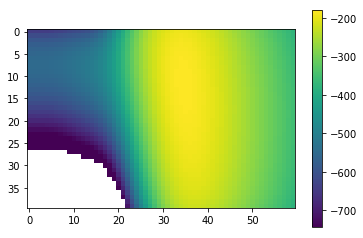

In [262]:
plt.imshow(np.log(raster))
plt.colorbar()

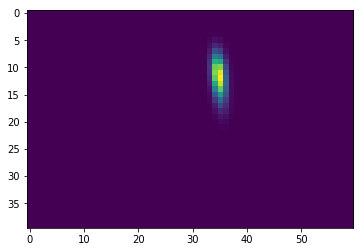

In [263]:
plt.imshow(raster)

In [287]:
m = raster.argmax() 
i, j = m // raster.shape[1], m % raster.shape[1]
assert raster.max() == raster[i,j]
ratio[i], tc[j] # These are the sensible coordinate values of the maximum

(0.34615384615384615, 92.491472772173353)